## Libraries

In [ ]:
import cooler
import cooltools
import pandas as pd
import bioframe
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
import copy

import multiprocess as mp
import multiprocessing as mpp
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Get 1st eigenvector

In [ ]:
NPROC = 8
resolution = 100_000

In [ ]:
clr = cooler.Cooler(
    f"/home/carlos/Desktop/manuscripts/notebooks/matrices/t0_q30.mcool::/resolutions/{resolution}"
)

view_df = pd.DataFrame(
    {
        "chrom": clr.chromnames,
        "start": 0,
        "end": clr.chromsizes.values,
        "name": clr.chromnames,
    }
)
bins = clr.bins()[:]

import bbi

bw = bins[["chrom", "start", "end"]]
stacks = bbi.stackup(
    "/home/carlos/Desktop/manuscripts/notebooks/bws/ENCFF144IVU.bigWig",
    bw["chrom"],
    bw["start"],
    bw["end"],
    bins=1,
)

x_norm = MinMaxScaler().fit_transform(stacks)
bw.loc[:, "BW"] = x_norm
samples = [0, 12, 30, 60]
eigen_data = []
n_eig = 1
map_ = mp.Pool(NPROC).map
from tqdm import tqdm

pbar = tqdm(total=len(samples))
for sample in samples:
    clr = cooler.Cooler(
        f"/home/carlos/Desktop/manuscripts/notebooks/matrices/t{sample}_q30.mcool::/resolutions/{resolution}"
    )

    cis_eigs = cooltools.eigs_cis(
        clr, bw, view_df=view_df, n_eigs=n_eig, map=map_, sort_metric="pearsonr"
    )
    eigen_data.append(cis_eigs)

    pbar.update(1)

In [ ]:
N_GROUPS = 4 # B1, B0, A0, A1
coseq_res_path = "/home/carlos/Desktop/manuscripts/notebooks/RNA/coseq_res"
clusters = [1,2,5,7,8]

Cluster 1


/tmp/ipykernel_11101/2966442921.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap_e1d.dropna(inplace=True)


Cluster 2
Cluster 5
Cluster 7
Cluster 8


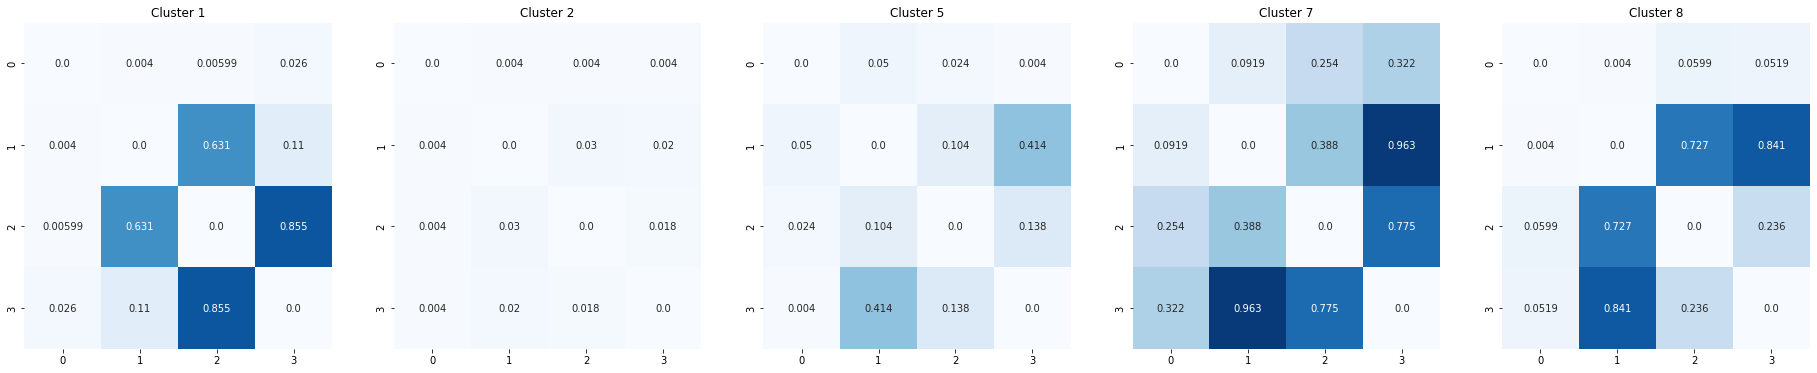

In [23]:
BSTRAP = 1000

Q_LO = 0.050
Q_HI = 0.975
DIGITIZE = True

if DIGITIZE:
    res = []
    for e_data, sample in zip(eigen_data, samples):
        track = e_data[1][["chrom", "start", "end", "E1"]]
        digits_df, _ = cooltools.digitize(track, n_bins=N_GROUPS, qrange=(Q_LO, Q_HI))
        digits_df["sample"] = [sample] * digits_df.shape[0]
        digits_df = digits_df[digits_df["E1.d"].isin([0, N_GROUPS + 1, -1]) == False]
        res.append(digits_df)
else:
    res = []
    for e_data, sample in zip(eigen_data, samples):
        res.append(e_data[1].rename(columns={"E1": "E1.d"}))

o1 = (
    bioframe.overlap(res[0], res[1], suffixes=["_0", "_12"], how="inner")
    .reset_index(drop=True)
    .rename(columns={"chrom_0": "chrom", "start_0": "start", "end_0": "end"})
)
o2 = (
    bioframe.overlap(o1, res[2], suffixes=["_0", "_30"], how="inner")
    .reset_index(drop=True)
    .rename(columns={"chrom_0": "chrom", "start_0": "start", "end_0": "end"})
)
o3 = (
    bioframe.overlap(o2, res[3], suffixes=["_0", "_60"], how="inner")
    .reset_index(drop=True)
    .rename(columns={"chrom_0": "chrom", "start_0": "start", "end_0": "end"})
)
o3.rename(
    columns={
        "E1.d_0_0_0": "Control",
        "E1.d_12_0_0": "12_mins",
        "E1.d_30_0": "30_mins",
        "E1.d_60": "60_mins",
    },
    inplace=True,
)
overlap_e1d = o3[
    ["chrom", "start", "end"] + ["Control", "12_mins", "30_mins", "60_mins"]
]
overlap_e1d.dropna(inplace=True)

from RyStats.common import polychoric


def process_rna_path(rna_df, e1d, verbose=False):
    df = bioframe.overlap(
        rna_df,
        e1d,
        cols1=["chrom", "start", "end"],
        cols2=["chrom", "start", "end"],
    )

    if verbose:
        print(df.shape[0])
    cols = ["Control_", "12_mins_", "30_mins_", "60_mins_"]
    v_ = [np.array(df[c]) for c in cols]
    if DIGITIZE:
        return (
            polychoric.polychoric_correlation(
                np.stack(v_), num_processors=1, start_val=1, stop_val=N_GROUPS
            ),
            df,
        )
    else:
        return df[cols].corr(), df


# cmp = sns.color_palette("light:b", as_cmap=True)

corr_original = []


n_genes_per_cluster = [0] * len(clusters)
for cluster in clusters:
    rna_path = f"{coseq_res_path}/{cluster}_runArcsin.geneIDs.0.9.tsv"

    rna_df = pd.read_csv(rna_path, sep="\t")
    rna_df.rename(
        columns={
            "chromosome_name": "chrom",
            "start_position": "start",
            "end_position": "end",
        },
        inplace=True,
    )
    rna_df.chrom = [f"chr{i}" for i in rna_df.chrom]
    corr, df = process_rna_path(rna_df, overlap_e1d)
    corr_original.append(corr)

    n_genes_per_cluster[clusters.index(cluster)] = len(set(df.genes))

corr_bg = []

rna_df_bg = clr.bins()[:]
rna_df_bg = rna_df_bg[["chrom", "start", "end"]]

# background


def process_random(bg_df, n_to_sample, seed, overlap_df):
    bg_df = bg_df.sample(n=n_to_sample, random_state=seed).reset_index(drop=True)
    return process_rna_path(bg_df, overlap_df, verbose=False)[0]
    
seeed = 42
local_corr_bg_per_cluster = []
for cluster in clusters:
    print(f"Cluster {cluster}")
    local_corr_bg = []
    n = n_genes_per_cluster[clusters.index(cluster)]
    with mpp.Pool(NPROC) as p:
        local_corr_bg = p.starmap(
            process_random, [(rna_df_bg, n, seeed * (i+1), overlap_e1d) for i in range(BSTRAP)]
        )
    local_corr_bg_per_cluster.append(local_corr_bg)
    corr_bg.append(np.mean(local_corr_bg, axis=0))

fig, ax = plt.subplots(nrows=1, ncols=len(clusters), figsize=(32, 6))
import scipy.stats as stats

# calculate p-values ~ 2-sided
p_matrix_ = [] 
for c in range(len(clusters)):
    dist = np.stack(local_corr_bg_per_cluster[c], axis=0)
    ori = corr_original[c]
    m = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            if i == j:
                continue
            else:
                p = np.sum(dist[:, i, j] > ori[i, j]) / (BSTRAP + 1)
                p = 2 * p if p < .5 else 2 * (1 - p) # two sided
                m[i, j] = p
    p_matrix_.append(m)
    
    sns.heatmap(
        m,
        ax=ax[c],
        vmin=0,
        vmax=1,
        cmap="Blues",
        cbar=False,
        annot=True,
        fmt=".3",
    ).set(title=f"Cluster {clusters[c]}")

In [24]:
#set plt fig dpi
plt.rcParams['figure.dpi'] = 300

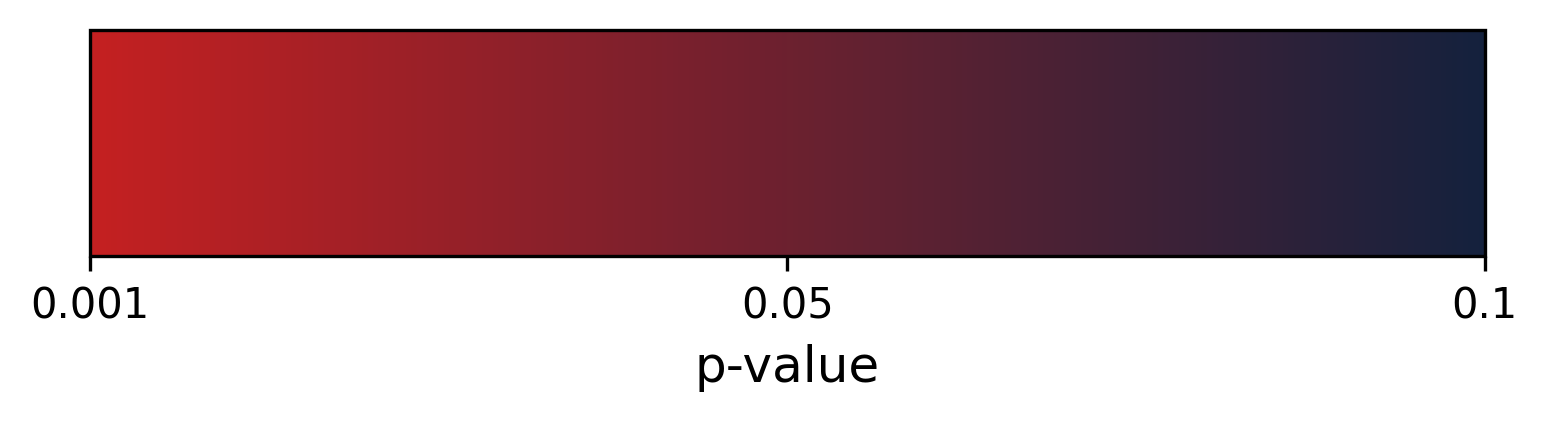

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define a colormap
custom_cmap = sns.color_palette("dark:salmon_r", as_cmap=True)

from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmp", ["#C42021", "#14213D"], N=256)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=ax, orientation='horizontal')

# Set the desired tick positions and labels
tick_positions = [0, 0.5, 1]
tick_labels = ['0.001', '0.05', '0.1']

# Set the ticks and tick labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

# Set color bar label
cbar.set_label('p-value', fontsize=12)

# Remove the x-axis labels and ticks
#ax.set_xticks([])
#ax.set_xticklabels([])

# Show the color bar
plt.show()

fig.savefig("pvalue.svg", bbox_inches='tight')


In [28]:
tcounts = "/home/carlos/Desktop/manuscripts/notebooks/RNA/runArcsin.tcounts.tsv"
tcounts_df = pd.read_csv(tcounts, sep="\t")
tcounts_df.geneId = tcounts_df.geneId.apply(lambda x: x.split(".")[0])
# take average of replicates such as mean of SU_100, SU_200, SU_300
for i, name in zip([0, 3, 6, 9], ["Control", "12min", "30min", "60min"]):
    tcounts_df[name] = tcounts_df.iloc[:, i : i + 3].mean(axis=1)

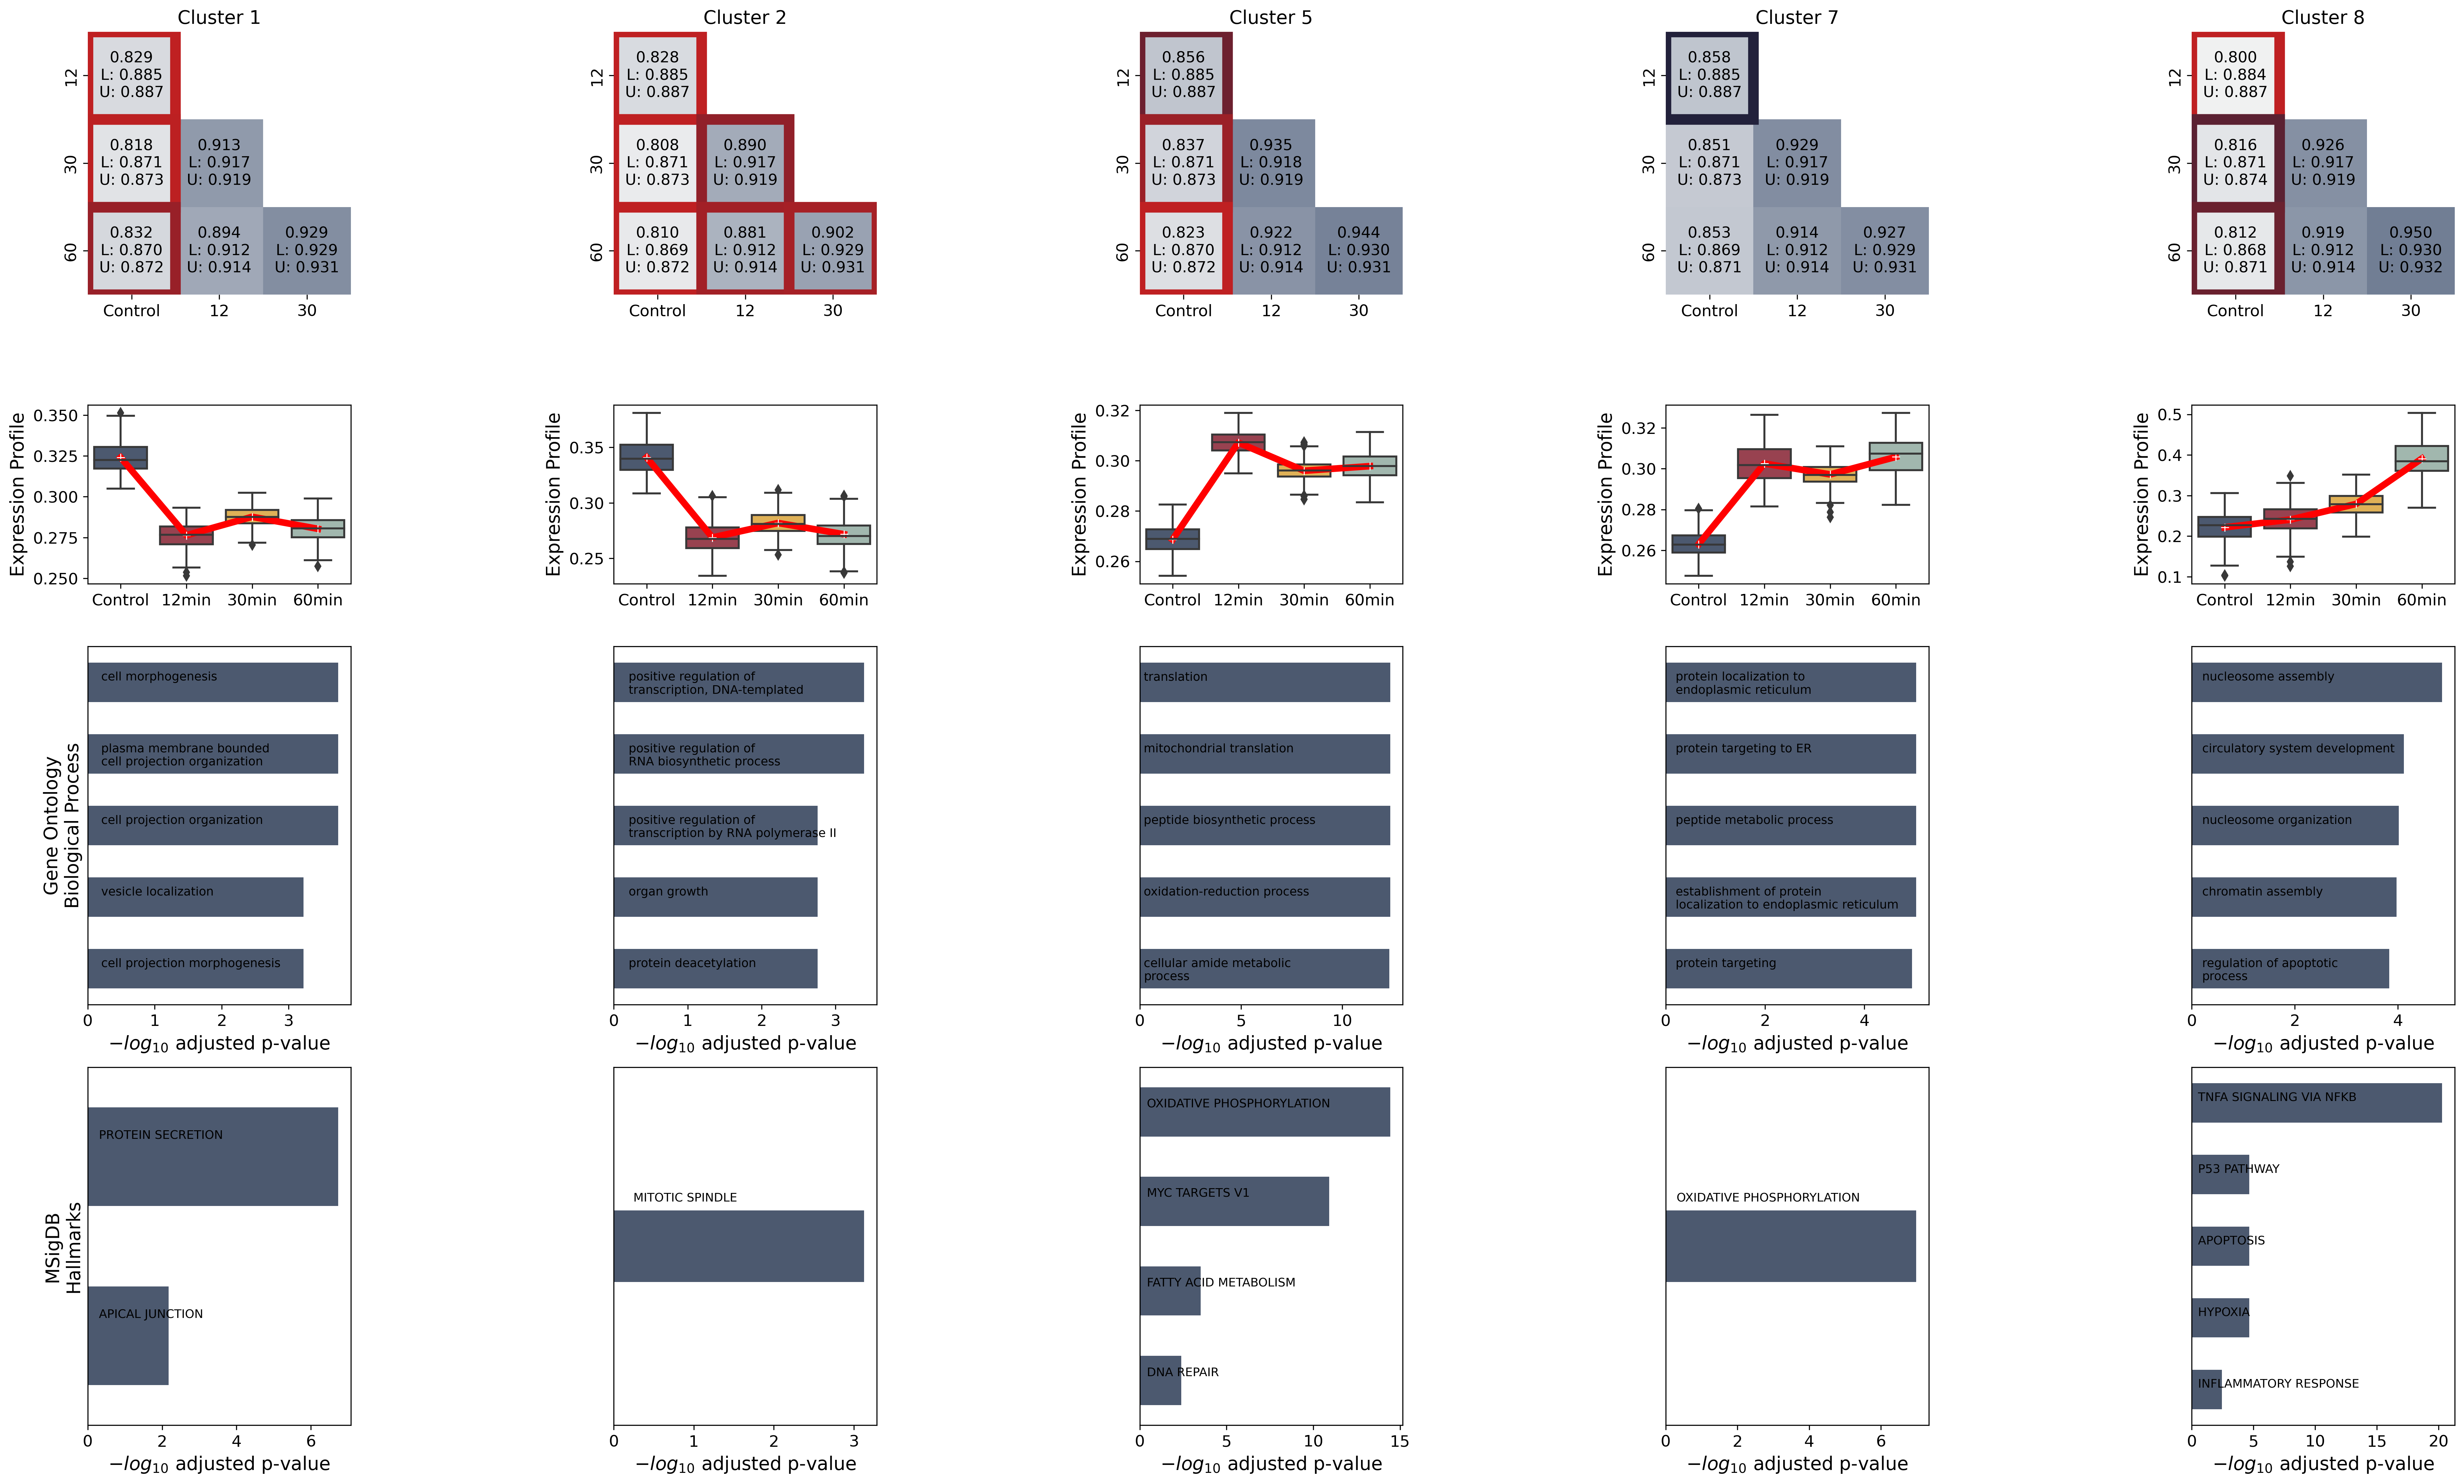

In [29]:
from matplotlib.colors import Normalize
p_val_color = Normalize(vmin=0.001, vmax=0.1)

import scipy.stats as stats

ci_labels_per_cluster = []
vmin = 1
CI = 0.95
cmp = sns.light_palette("#465775", as_cmap=True)

def mean_confidence_interval(data, confidence=0.95):
    n = data.shape[0]
    m, se = np.mean(data, axis=0), stats.sem(data, axis=0)
    h = se * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h


for i, cluster in enumerate(clusters):
    _, ci_l, ci_u = mean_confidence_interval(
        np.stack(local_corr_bg_per_cluster[i], axis=0), CI
    )
    d = list(
        map(
            lambda x: str("%.3f" % x),
            list(corr_original[clusters.index(cluster)].flatten()),
        )
    )
    l = list(
        map(
            lambda x: f'\nL: {str("%.3f" % x)}' if x != "nan" else "",
            list(ci_l.flatten()),
        )
    )
    u = list(
        map(
            lambda x: f'\nU: {str("%.3f" % x)}' if x != "nan" else "",
            list(ci_u.flatten()),
        )
    )
    labels = np.char.add(d, np.char.add(l, u)).reshape(4, 4)
    labels[labels == "1.000\nL: nan\nU: nan"] = "1"
    ci_labels_per_cluster.append(labels)
    curr_min = np.min(corr_original[i])
    if vmin > curr_min:
        vmin = curr_min


fig, ax = plt.subplots(nrows=4, ncols=len(clusters), figsize=(32, 20), gridspec_kw={'height_ratios': [1, .5, 1, 1], 'width_ratios': [1, 1, 1, 1, 1]})
#plt.subplots_adjust(wspace=0.85, hspace=0.001)
plt.subplots_adjust(wspace=1)

for i, cluster in enumerate(clusters):
    m = corr_original[clusters.index(cluster)]
    m = m[1:, :-1]
    m[m == np.nan] = 1

    labels = ci_labels_per_cluster[i][1:, :-1]

    mask = np.zeros_like(m)
    mask[np.triu_indices_from(mask, k=1)] = True
    m[np.isnan(m)] = 1
    s = sns.heatmap(
        m,
        vmin=float(vmin),
        vmax=1,
        mask=mask,
        square=True,
        xticklabels=["Control", "12", "30"],
        yticklabels=["12", "30", "60"],
        annot=labels,
        cmap=cmp,
        cbar=False,
        ax=ax[0, i],
        fmt="",
        annot_kws={"fontsize": 11.5, "color": "black"},
    )

    #s.set_title(f"Cluster {cluster}\n{CI} CI - Lower, Upper\n# Bootstrap: {BSTRAP}", fontsize=14)
    s.set_title(f"Cluster {cluster}", fontsize=14)

    s.tick_params(axis='y', labelsize=12)
    s.tick_params(axis='x', labelsize=12)

    curr_p_matrix = np.stack(p_matrix_)[i,:,:][1:, :-1]
    curr_p_matrix[np.triu_indices_from(curr_p_matrix, k=1)] = 1
    (x_coord,y_coord) = np.where(curr_p_matrix < 0.1) 

    #cmp_pval = sns.color_palette("dark:salmon_r", as_cmap=True)
    cmp_pval = LinearSegmentedColormap.from_list("custom_cmp", ["#C42021", "#14213D"], N=256)
    for x, y in zip(x_coord, y_coord):
        curr_color = cmp_pval(p_val_color(curr_p_matrix[x, y]))
        ax[0, i].add_patch(plt.Rectangle((y, x), 1, 1, fill=False, color=curr_color, lw=8))


    rna_path = f"{coseq_res_path}/{cluster}_runArcsin.geneIDs.0.9.tsv"

    rna_df = pd.read_csv(rna_path, sep="\t")
    curr_genes = rna_df['gene_id'].values
    curr_genes_counts_df = tcounts_df.loc[tcounts_df.geneId.isin(curr_genes)]
    curr_genes_counts_melted = curr_genes_counts_df.melt(id_vars=['geneId'], value_vars=['Control', '12min', '30min', '60min'])

    order = ["Control", "12min", "30min", "60min"]
    df_2 = curr_genes_counts_melted.copy()
    df_2['variable'] = pd.Categorical(df_2['variable'], order)
    df_2.sort_values('variable', inplace=True)
    
    b = sns.boxplot(data=curr_genes_counts_melted, x="variable", y="value", ax=ax[1, i], palette=["#465775", "#A63446", "#F5B841", "#9DBBAE"])
    sns.lineplot(x='variable', y='value', data=df_2, color='r', marker='+', linewidth=5, ax=ax[1, i])
    b.set(xlabel=None)
    b.set_ylabel('Expression Profile', fontsize=14)
    b.tick_params(axis='y', labelsize=12)
    b.tick_params(axis='x', labelsize=12)

    enrichment_dict = {"ego": "Gene Ontology\nBiological Process", "msig_h": "MSigDB\nHallmarks"}
    for enrichment_idx, which_enrichment in enumerate(["ego", "msig_h"]):

        ego_Df = pd.read_csv(
            f"{coseq_res_path}/{cluster}_runArcsin.{which_enrichment}.tsv",
            sep="\t",
        )

        ego_Df = ego_Df.drop_duplicates(subset=["GeneRatio", "BgRatio"], inplace=False)
        df = ego_Df.sort_values(by=["qvalue", "p.adjust"], ascending=True).head(5)
        df.Description = df.Description.apply(lambda x: " ".join(x.split("_")))



        def split_name(name, line_length=30):
            name = name.replace("HALLMARK", "")
            n_char = len(name)
            possible_junctions = [i for i in range(n_char) if name[i] == " "]
            if n_char > line_length:
                if len(possible_junctions) == 0:
                    return name[:line_length] + "\n" + name[line_length:]
                else:
                    return name[: possible_junctions[2]] + "\n" + name[possible_junctions[2] + 1 :]
            else:
                return name

        df['p.adjust'] = -np.log10(df['p.adjust'])

        b_width = 0.2 if len(df) == 1 else 0.55
        b = sns.barplot(
            data=df,
            x="p.adjust",
            y="Description",
            ax=ax[2+enrichment_idx, i],
            color="#465775",
            width=b_width,
        )

        b.set_title("")
        b.set_ylabel(enrichment_dict[which_enrichment],fontsize=14) if i == 0 else b.set_ylabel(None)

        log10_padj_str = "$-log_{10}$"
        b.set_xlabel(xlabel=log10_padj_str + " adjusted p-value", fontsize=14)


        b.tick_params(axis='x', labelsize=12)

        height_list = df['p.adjust'].values
        nameslist = df['Description'].values

        xlim = b.get_xlim()
        midpoint = np.mean(xlim)
        start_point = xlim[0]
        for i_pos, (name, height) in enumerate(zip(nameslist, height_list)):
            b.text(start_point+0.2, i_pos-0.15, split_name(name), color='black',
                    ha='left', va='top', 
                    rotation=0, fontsize=9)

        b.set_yticks([])
        

fig.savefig(
    f"{resolution}_{N_GROUPS}_corr_wBG_bs{BSTRAP}_CI{CI}_GO.svg",
    bbox_inches="tight",
)